<a href="https://colab.research.google.com/github/saku-s3/21101597_-_-/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5_%ED%82%A5%EB%B3%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import random
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

def _pick_existing(*candidates: Path) -> Path:
    for p in candidates:
        if p.exists() and p.is_dir():
            return p
    raise FileNotFoundError(f"Cannot find any of these directories: {[str(c) for c in candidates]}")

def _collect_images(dir_path: Path, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")):
    paths = []
    for ext in exts:
        paths.extend(dir_path.rglob(f"*{ext}"))
        paths.extend(dir_path.rglob(f"*{ext.upper()}"))
    paths = [p for p in paths if p.is_file()]
    return sorted(paths)

def _filter_valid_images(paths):
    valid = []
    for p in paths:
        try:
            with Image.open(p) as im:
                im.verify()
            valid.append(p)
        except Exception:
            pass
    return valid

class BinaryImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

BASE_DIR = Path("/content/drive/MyDrive/기계학습_공유킥보드")

train_other_dir = _pick_existing(
    BASE_DIR / "train" / "other_objects",
    BASE_DIR / "train-other_objects"
)
train_shared_dir = _pick_existing(
    BASE_DIR / "train" / "shared_scooters",
    BASE_DIR / "train-shared_scooters",
    BASE_DIR / "train-shared_scooter"
)

test_other_dir = _pick_existing(
    BASE_DIR / "test" / "other_objects",
    BASE_DIR / "test-other_objects"
)
test_shared_dir = _pick_existing(
    BASE_DIR / "test" / "shared_scooters",
    BASE_DIR / "test-shared_scooters",
    BASE_DIR / "test-shared_scooter"
)

train_other = _collect_images(train_other_dir)
train_shared = _collect_images(train_shared_dir)
test_other = _collect_images(test_other_dir)
test_shared = _collect_images(test_shared_dir)

train_other = _filter_valid_images(train_other)
train_shared = _filter_valid_images(train_shared)
test_other = _filter_valid_images(test_other)
test_shared = _filter_valid_images(test_shared)

label_map = {"other_objects": 0, "shared_scooters": 1}

train_paths = train_other + train_shared
train_labels = [label_map["other_objects"]] * len(train_other) + [label_map["shared_scooters"]] * len(train_shared)

test_paths = test_other + test_shared
test_labels = [label_map["other_objects"]] * len(test_other) + [label_map["shared_scooters"]] * len(test_shared)

rng = list(range(len(train_paths)))
random.seed(42)
random.shuffle(rng)

train_paths = [train_paths[i] for i in rng]
train_labels = [train_labels[i] for i in rng]

val_ratio = 0.2
val_size = int(len(train_paths) * val_ratio)

val_paths = train_paths[:val_size]
val_labels = train_labels[:val_size]
tr_paths = train_paths[val_size:]
tr_labels = train_labels[val_size:]

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_ds = BinaryImageDataset(tr_paths, tr_labels, transform=train_tf)
val_ds = BinaryImageDataset(val_paths, val_labels, transform=eval_tf)
test_ds = BinaryImageDataset(test_paths, test_labels, transform=eval_tf)

batch_size = 32
num_workers = 2

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("BASE_DIR:", BASE_DIR)
print("Train other_objects:", len(train_other))
print("Train shared_scooters:", len(train_shared))
print("Val size:", len(val_ds))
print("Train size:", len(train_ds))
print("Test other_objects:", len(test_other))
print("Test shared_scooters:", len(test_shared))
print("Test size:", len(test_ds))

x, y = next(iter(train_loader))
print("Batch x:", x.shape, "Batch y:", y.shape, "y unique:", torch.unique(y))


Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/기계학습_공유킥보드
Train other_objects: 233
Train shared_scooters: 192
Val size: 85
Train size: 340
Test other_objects: 9
Test shared_scooters: 8
Test size: 17


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch x: torch.Size([32, 3, 224, 224]) Batch y: torch.Size([32]) y unique: tensor([0, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dropout_p = 0.3
num_epochs = 15
lr = 3e-4
weight_decay = 1e-4

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(in_features, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

def _metrics_binary_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    y = labels

    tp = ((preds == 1) & (y == 1)).sum().item()
    tn = ((preds == 0) & (y == 0)).sum().item()
    fp = ((preds == 1) & (y == 0)).sum().item()
    fn = ((preds == 0) & (y == 1)).sum().item()

    acc = (tp + tn) / max(tp + tn + fp + fn, 1)
    prec = tp / max(tp + fp, 1)
    rec = tp / max(tp + fn, 1)
    f1 = (2 * prec * rec) / max(prec + rec, 1e-12)

    return acc, prec, rec, f1, (tn, fp, fn, tp)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    all_logits = []
    all_labels = []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        all_logits.append(logits)
        all_labels.append(y)
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    avg_loss = total_loss / max(len(all_labels), 1)
    acc, prec, rec, f1, cm = _metrics_binary_from_logits(all_logits, all_labels)
    return avg_loss, acc, prec, rec, f1, cm

def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / max(len(loader.dataset), 1)

best_val_f1 = -1.0
best_path = "/content/best_resnet_dropout.pt"

for epoch in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_cm = evaluate(val_loader)
    scheduler.step()

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_path)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
          f"val_acc={val_acc:.4f} val_prec={val_prec:.4f} val_rec={val_rec:.4f} val_f1={val_f1:.4f} | "
          f"cm(tn,fp,fn,tp)={val_cm}")

model.load_state_dict(torch.load(best_path, map_location=device))
test_loss, test_acc, test_prec, test_rec, test_f1, test_cm = evaluate(test_loader)

print("TEST | "
      f"loss={test_loss:.4f} acc={test_acc:.4f} prec={test_prec:.4f} rec={test_rec:.4f} f1={test_f1:.4f} | "
      f"cm(tn,fp,fn,tp)={test_cm}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 67.5MB/s]


Epoch 1/15 | train_loss=0.2821 | val_loss=0.2566 | val_acc=0.9294 val_prec=0.8500 val_rec=1.0000 val_f1=0.9189 | cm(tn,fp,fn,tp)=(45, 6, 0, 34)
Epoch 2/15 | train_loss=0.0328 | val_loss=0.0400 | val_acc=0.9882 val_prec=1.0000 val_rec=0.9706 val_f1=0.9851 | cm(tn,fp,fn,tp)=(51, 0, 1, 33)
Epoch 3/15 | train_loss=0.0171 | val_loss=0.0469 | val_acc=0.9882 val_prec=1.0000 val_rec=0.9706 val_f1=0.9851 | cm(tn,fp,fn,tp)=(51, 0, 1, 33)
Epoch 4/15 | train_loss=0.0122 | val_loss=0.1143 | val_acc=0.9882 val_prec=1.0000 val_rec=0.9706 val_f1=0.9851 | cm(tn,fp,fn,tp)=(51, 0, 1, 33)
Epoch 5/15 | train_loss=0.0095 | val_loss=0.1705 | val_acc=0.9765 val_prec=0.9706 val_rec=0.9706 val_f1=0.9706 | cm(tn,fp,fn,tp)=(50, 1, 1, 33)
Epoch 6/15 | train_loss=0.0114 | val_loss=0.0938 | val_acc=0.9882 val_prec=1.0000 val_rec=0.9706 val_f1=0.9851 | cm(tn,fp,fn,tp)=(51, 0, 1, 33)
Epoch 7/15 | train_loss=0.0140 | val_loss=0.0572 | val_acc=0.9765 val_prec=0.9706 val_rec=0.9706 val_f1=0.9706 | cm(tn,fp,fn,tp)=(50, 1,

[resnet18_scratch] Epoch 1/60 | lr=0.012500 | train_loss=0.7549 | val_loss=0.6208 | val_acc=0.7059 val_f1=0.5614 | cm=
[[44  7]
 [18 16]]
[resnet18_scratch] Epoch 2/60 | lr=0.012500 | train_loss=0.7319 | val_loss=0.6645 | val_acc=0.6000 val_f1=0.1500 | cm=
[[48  3]
 [31  3]]
[resnet18_scratch] Epoch 3/60 | lr=0.012500 | train_loss=0.8293 | val_loss=0.5855 | val_acc=0.7059 val_f1=0.4898 | cm=
[[48  3]
 [22 12]]
[resnet18_scratch] Epoch 4/60 | lr=0.012500 | train_loss=0.9734 | val_loss=1.4101 | val_acc=0.5176 val_f1=0.5176 | cm=
[[22 29]
 [12 22]]
[resnet18_scratch] Epoch 5/60 | lr=0.012500 | train_loss=1.2572 | val_loss=32.1338 | val_acc=0.6000 val_f1=0.0000 | cm=
[[51  0]
 [34  0]]
[resnet18_scratch] Epoch 6/60 | lr=0.012500 | train_loss=0.9768 | val_loss=18.6522 | val_acc=0.6000 val_f1=0.0000 | cm=
[[51  0]
 [34  0]]
[resnet18_scratch] Epoch 7/60 | lr=0.012500 | train_loss=0.8513 | val_loss=2.8229 | val_acc=0.4000 val_f1=0.5714 | cm=
[[ 0 51]
 [ 0 34]]
[resnet18_scratch] Epoch 8/60 | 

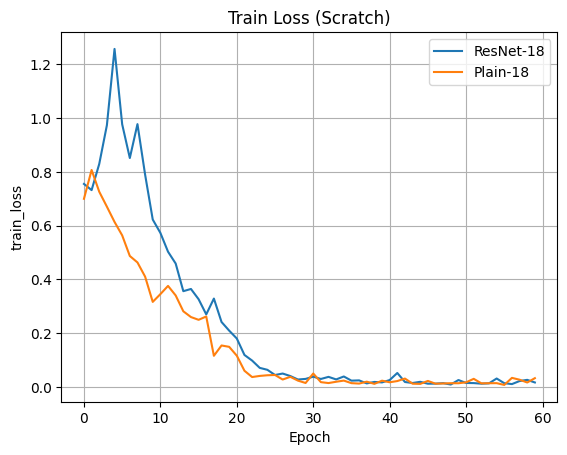

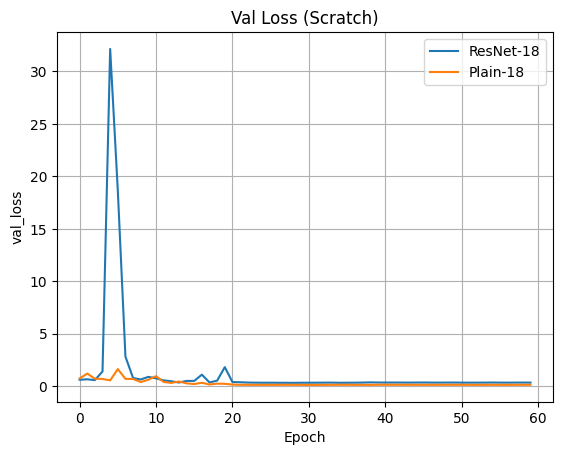

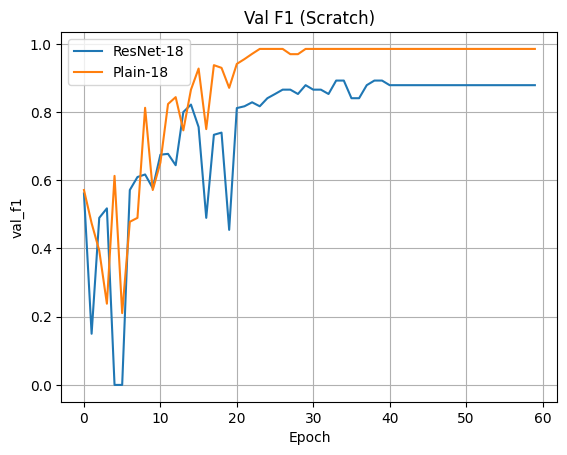

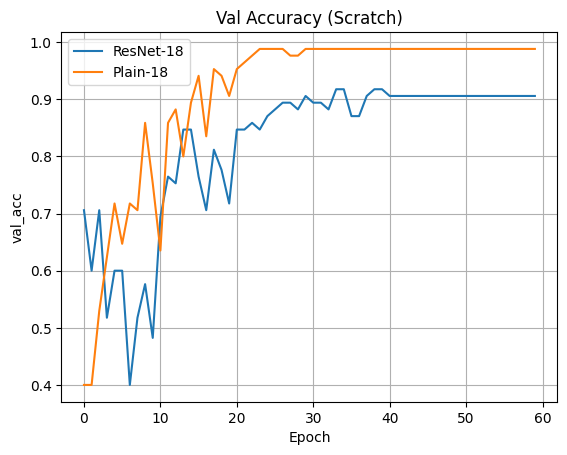

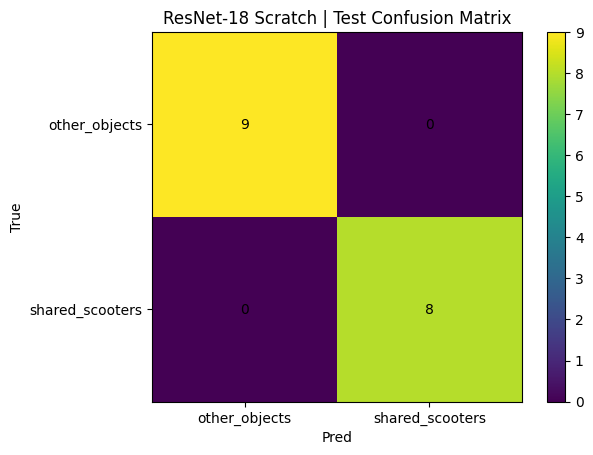

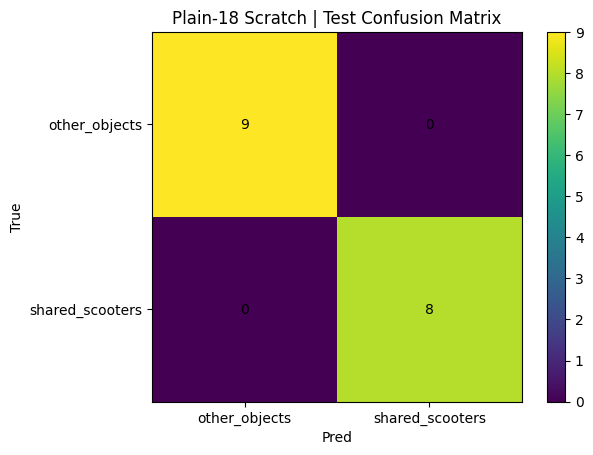

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ResNet-18 Scratch | Misclassified (Test) : 오분류가 없음
Plain-18 Scratch | Misclassified (Test) : 오분류가 없음
SUMMARY
ResNet-18 scratch test: {'loss': 0.011996189132332802, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'cm': array([[9, 0],
       [0, 8]])}
Plain-18 scratch test: {'loss': 0.010775629431009293, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'cm': array([[9, 0],
       [0, 8]])}


In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# ---- Plain block: ResNet의 skip(add)만 제거 ----
class PlainBasicBlock(models.resnet.BasicBlock):
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

def build_model(model_type="resnet18", dropout_p=0.0):
    if model_type == "resnet18":
        model = models.resnet18(weights=None)  # <- scratch (다운로드 절대 없음)
    elif model_type == "plain18":
        model = models.resnet.ResNet(block=PlainBasicBlock, layers=[2,2,2,2], num_classes=1000)
    else:
        raise ValueError("model_type must be 'resnet18' or 'plain18'")

    in_features = model.fc.in_features
    if dropout_p > 0:
        model.fc = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(in_features, 2))
    else:
        model.fc = nn.Linear(in_features, 2)
    return model

def metrics_from_logits(logits, y):
    pred = torch.argmax(logits, dim=1)

    tp = ((pred == 1) & (y == 1)).sum().item()
    tn = ((pred == 0) & (y == 0)).sum().item()
    fp = ((pred == 1) & (y == 0)).sum().item()
    fn = ((pred == 0) & (y == 1)).sum().item()

    acc = (tp + tn) / max(tp + tn + fp + fn, 1)
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec) / max(prec + rec, 1e-12)
    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)
    return acc, prec, rec, f1, cm

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_logits, all_y = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        all_logits.append(logits)
        all_y.append(y)
    all_logits = torch.cat(all_logits, dim=0)
    all_y = torch.cat(all_y, dim=0)
    avg_loss = total_loss / max(len(all_y), 1)
    acc, prec, rec, f1, cm = metrics_from_logits(all_logits, all_y)
    return avg_loss, acc, prec, rec, f1, cm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    return total_loss / max(len(loader.dataset), 1)

def run_experiment(model_type, name, epochs=60, dropout_p=0.0):
    model = build_model(model_type=model_type, dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()

    bs = train_loader.batch_size if hasattr(train_loader, "batch_size") else 32
    lr = 0.1 * (bs / 256.0)        # ResNet 논문 스타일(배치에 따라 스케일)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_f1": [],
        "val_acc": []
    }

    best_val_f1 = -1.0
    best_path = f"/content/best_{name}.pt"

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_prec, val_rec, val_f1, val_cm = evaluate(model, val_loader, criterion)
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)
        history["val_acc"].append(val_acc)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_path)

        print(f"[{name}] Epoch {epoch}/{epochs} | lr={optimizer.param_groups[0]['lr']:.6f} | "
              f"train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
              f"val_acc={val_acc:.4f} val_f1={val_f1:.4f} | cm=\n{val_cm}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    test_loss, test_acc, test_prec, test_rec, test_f1, test_cm = evaluate(model, test_loader, criterion)

    result = {
        "name": name,
        "model": model,
        "history": history,
        "best_val_f1": best_val_f1,
        "test": {
            "loss": test_loss,
            "acc": test_acc,
            "prec": test_prec,
            "rec": test_rec,
            "f1": test_f1,
            "cm": test_cm
        }
    }

    print(f"\n[{name}] TEST | loss={test_loss:.4f} acc={test_acc:.4f} "
          f"prec={test_prec:.4f} rec={test_rec:.4f} f1={test_f1:.4f}\nCM=\n{test_cm}\n")
    return result

# ---------- 실행 ----------
# dropout_p는 "둘 다 동일하게" 넣어야 공정 비교됨 (논문 기본은 0.0 추천)
EPOCHS = 60
dropout_p = 0.0

resnet_out = run_experiment("resnet18", "resnet18_scratch", epochs=EPOCHS, dropout_p=dropout_p)
plain_out  = run_experiment("plain18",  "plain18_scratch",  epochs=EPOCHS, dropout_p=dropout_p)

# ---------- 시각화 ----------
def plot_curves(resnet_hist, plain_hist, key, title):
    plt.figure()
    plt.plot(resnet_hist[key], label="ResNet-18")
    plt.plot(plain_hist[key], label="Plain-18")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curves(resnet_out["history"], plain_out["history"], "train_loss", "Train Loss (Scratch)")
plot_curves(resnet_out["history"], plain_out["history"], "val_loss",   "Val Loss (Scratch)")
plot_curves(resnet_out["history"], plain_out["history"], "val_f1",     "Val F1 (Scratch)")
plot_curves(resnet_out["history"], plain_out["history"], "val_acc",    "Val Accuracy (Scratch)")

def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.xticks([0,1], ["other_objects", "shared_scooters"])
    plt.yticks([0,1], ["other_objects", "shared_scooters"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar()
    plt.show()

plot_confusion_matrix(resnet_out["test"]["cm"], "ResNet-18 Scratch | Test Confusion Matrix")
plot_confusion_matrix(plain_out["test"]["cm"],  "Plain-18 Scratch | Test Confusion Matrix")

# ---------- 오분류 샘플 시각화(테스트에서 틀린 것만 뽑아서 최대 N개 보여줌) ----------
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(x):
    x = x.cpu() * imagenet_std + imagenet_mean
    return torch.clamp(x, 0, 1)

@torch.no_grad()
def show_misclassified(model, loader, max_n=12, title="Misclassified"):
    model.eval()
    imgs, true_y, pred_y = [], [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        p = torch.argmax(logits, dim=1)
        wrong = (p != y)
        if wrong.any():
            xs = x[wrong]
            ys = y[wrong]
            ps = p[wrong]
            for i in range(xs.size(0)):
                imgs.append(unnormalize(xs[i]))
                true_y.append(int(ys[i].item()))
                pred_y.append(int(ps[i].item()))
                if len(imgs) >= max_n:
                    break
        if len(imgs) >= max_n:
            break

    if len(imgs) == 0:
        print(title, ": 오분류가 없음")
        return

    cols = 4
    rows = (len(imgs) + cols - 1) // cols
    plt.figure(figsize=(12, 3 * rows))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.permute(1,2,0))
        t = "shared_scooters" if true_y[i] == 1 else "other_objects"
        p = "shared_scooters" if pred_y[i] == 1 else "other_objects"
        plt.title(f"T:{t}\nP:{p}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_misclassified(resnet_out["model"], test_loader, max_n=12, title="ResNet-18 Scratch | Misclassified (Test)")
show_misclassified(plain_out["model"],  test_loader, max_n=12, title="Plain-18 Scratch | Misclassified (Test)")

print("SUMMARY")
print("ResNet-18 scratch test:", resnet_out["test"])
print("Plain-18 scratch test:", plain_out["test"])
